In [0]:
!pip install transformers datasets bitsandbytes peft trl accelerate torch nvidia-cutlass deepspeed


  Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl.metadata (2.9 kB)
  Using cached peft-0.14.0-py3-none-any.whl.metadata (13 kB)
  Using cached trl-0.13.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cutlass-3.6.0.0-py3-none-any.whl.metadata (29 kB)
  Using cached huggingface_hub-0.27.1-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-1.2.1-py3-none-any.whl.metadata (19 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached cuda_python-12.6.2.post1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached pydot-3.0.4-py3-none-any.whl.metadata (10 kB)
  Using cached treelib-1.7.0-py3-none-any.whl.metadata (1.3 kB)
Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl (69.1 MB)
Using cached peft-0.1

In [0]:
### The nvidia-ml-py3 library allows us to monitor the memory usage of the models from within Python

In [0]:
%restart_python

In [0]:
import torch 
import os
from datasets import load_dataset # load datasets from hugging face 
from transformers import (AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig,HfArgumentParser, TrainingArguments, pipeline, logging, Trainer, DataCollatorForSeq2Seq) ## get models from hugging face 
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training ## configure the model 
from trl import SFTTrainer, SFTConfig ## the actual trainer is from trl 
import gc
import pandas as pd
os.environ["PYTORCH_CUDA_ALLOC_CONF"] ="expandable_segments:True"
torch.cuda.empty_cache()
# import deepspeed


2025-01-08 17:21:02.894273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736356862.905952   29105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736356862.909571   29105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 17:21:02.923132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:

# password = getpass.getpass()
command = "sudo apt update" #can be any command but don't forget -S as it enables input from stdin
os.system(command=command)

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64  InRelease
Hit:2 https://repos.azul.com/zulu/deb stable InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:4 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists...
Building dependency tree...
Reading state information...
118 packages can be upgraded. Run 'apt list --upgradable' to see them.


W: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2404/x86_64/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: https://repos.azul.com/zulu/deb/dists/stable/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.


0

In [0]:
command_2 = "sudo apt-get -y install libaio-dev"
os.system(command=command_2)

Reading package lists...
Building dependency tree...
Reading state information...
libaio-dev is already the newest version (0.3.113-6build1).
0 upgraded, 0 newly installed, 0 to remove and 118 not upgraded.


0

In [0]:
os.environ['HF_TOKEN'] = ""

In [0]:
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization process (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

model_name = "google/gemma-2b-it"
bnb_config = BitsAndBytesConfig(load_in_4bit= use_4bit, bnb_4bit_quant_type= bnb_4bit_quant_type, bnb_4bit_compute_dtype= bnb_4bit_compute_dtype, bnb_4bit_use_double_quant= use_nested_quant) ## perform computations in google brain float 16 format 
# no need to quatize the tokenizer of the model. 
tokenizer = AutoTokenizer.from_pretrained(model_name, token = os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map={"":0}, token = os.environ['HF_TOKEN'],) ## downloading the model in a 4bit format from hugging face 
## right now it is in memory 

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [0]:
## now lets play with the model
text = "Tell me about the moon landing"
# tokenizer.pad_token = tokenizer.eos_token
input = tokenizer(text, return_tensors="pt").to("cuda")
output = model.generate(**input, max_new_tokens=300)
decoded = tokenizer.decode(output[0], skip_special_tokens=True)
print(decoded)

Tell em about the moon landing.

The moon landing, one of the most significant achievements in human history, took place from July 16th to July 24th, 1969, when the Apollo 11 mission became the first manned mission to land on the Moon. The landing was a culmination of years of research, development, and training, and it marked a major milestone in the history of humankind.

The mission was led by Neil Armstrong, the first person to walk on the Moon, and Buzz Aldrin, the second person to walk on the Moon. The astronauts spent more than two days on the Moon, conducting scientific experiments and exploring the lunar surface. They also planted an American flag on the Moon's surface.

The moon landing had a profound impact on the world, inspiring a generation of people and fostering international cooperation. It also raised important questions about the nature of humanity and our place in the universe.

Here are some key facts about the moon landing:

* The mission was a joint effort betwee

In [0]:
## lets load the dataset
dataset_path = "mamachang/medical-reasoning"
dataset = load_dataset("mamachang/medical-reasoning", split = 'train')
print(dataset)

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Dataset({
    features: ['input', 'instruction', 'output'],
    num_rows: 3702
})


In [0]:
inputs_column = dataset['input']
dataframe = pd.DataFrame(inputs_column, columns=['input'])
print(dataframe.isna().sum())

input    0
dtype: int64


In [0]:
dataset['input'][0]

"Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? \n{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in the urine', 'D': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, and urinary monoclonal spike', 'E': 'Hyperuricemia

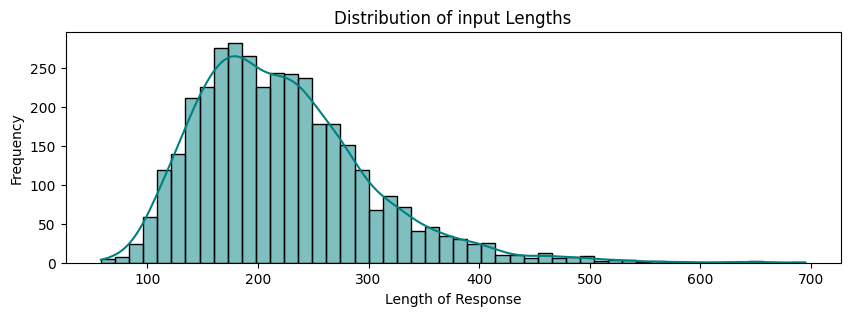

In [0]:
## look at the distribution of the dataset 
input_lengths = [len(tokenizer(dataset['input'][i])['input_ids'])for i in range(len(dataset['input']))]
output_lengths = [len(tokenizer(dataset['output'][i])['input_ids']) for i in range(len(dataset['output']))]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 3))
sns.histplot(np.asarray(input_lengths), bins=50, kde=True, color='teal')
plt.title('Distribution of input Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()


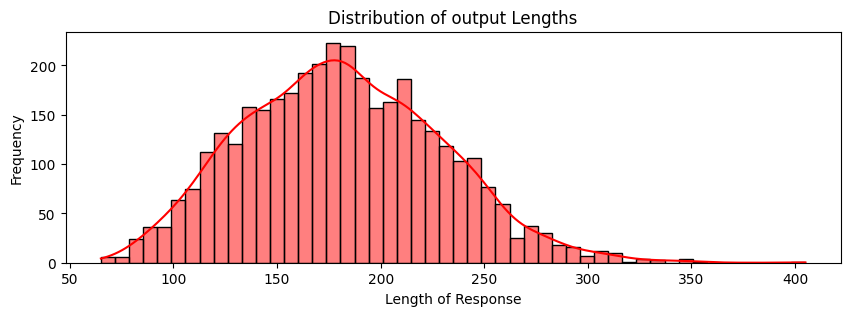

In [0]:
plt.figure(figsize=(10, 3))
sns.histplot(np.asarray(output_lengths), bins=50, kde=True, color='red')
plt.title('Distribution of output Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

Format dataset to be a chat

## Preparing dataset without torch utils dataset

In [0]:
### prep the dataset for SFT
### since we are using an instruct model, we will use a chat format to train it 
### this inlcudes adding the answer in the prompt 
def format_exmaple(example):

    chat = [
  {"role": "system", "content": "You are a helpful assistant who is an expert in enlgish quotes. Take the input quote given by the user and name the author of the quote. Use the following as exmaples: \\n"},
  {"role": "user", "content": example['quote']},
  {"role": "assistant", "content": example['author']},
]
    prompt = tokenizer.apply_chat_template(
    chat, tokenize=False, add_generation_prompt=True
)
    return {'prompt': prompt}


new_dataset = dataset.map(format_exmaple)


Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

In [0]:
print(new_dataset[0])

{'quote': '“Be yourself; everyone else is already taken.”', 'author': 'Oscar Wilde', 'tags': ['be-yourself', 'gilbert-perreira', 'honesty', 'inspirational', 'misattributed-oscar-wilde', 'quote-investigator'], 'prompt': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 06 Jan 2025\n\nYou are a helpful assistant who is an expert in enlgish quotes. Take the input quote given by the user and name the author of the quote. Use the following as exmaples: \\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n“Be yourself; everyone else is already taken.”<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nOscar Wilde<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'}


## dataset preparation using torch utils dataset 

In [0]:
## this is for preparing the data using Torch.Dataset

def format_quote(example):

    chat = [
{"role": "system", "content": "You are a helpful assistant who is an expert in enlgish quotes. Take the input quote given by the user and name the author of the quote. Here is the input quote \\n"},
{"role": "user", "content": example['quote']},
]
    prompt = tokenizer.apply_chat_template(
    chat, tokenize=False, add_generation_prompt=True
)
    return {'format_quote': prompt}


In [0]:
training_dataset_2 = dataset.map(format_quote)

In [0]:
## define torch dataset
from torch.utils.data import Dataset

class TrainingData(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs["input_ids"])
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx], 
            "labels": self.labels[idx]
        }


tokenizer.pad_token = tokenizer.eos_token
quotes = [training_dataset_2['format_quote'][i] for i in range(len(training_dataset_2['format_quote']))]
authors = [training_dataset_2['author'][i] for i in range(len(training_dataset_2['author']))]
# Set a consistent max length
max_length = 50

# Tokenize prompts and responses
tokenized_inputs = tokenizer(quotes, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
tokenized_labels = tokenizer(authors, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")["input_ids"]

# Ensure labels' padding tokens are ignored in loss computation
tokenized_labels[tokenized_labels == tokenizer.pad_token_id] = -100

dataset_to_train = TrainingData(tokenized_inputs, tokenized_labels)

# Data collator to handle padding (dynamically handle padding)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)


## Prepare medical dataset for training

In [0]:
### Gemma prompt 
def medical_prompt(data_point):
  
    # Generate prompt
    system_text = 'You are a hepful assistant that is an expert wihtin the medical field. Please complete the following task and write a response based on the requirements stated below. \\n'
    # Samples with additional context into.
    if data_point['input']:
        text = f"""<start_of_turn>user {system_text} {data_point["instruction"]} here are the inputs {data_point["input"]} <end_of_turn>\n<start_of_turn>model{data_point["output"]} <end_of_turn>"""
    # Without
    else:
        text = f"""<start_of_turn>user {system_text} {data_point["instruction"]} <end_of_turn>\n<start_of_turn>model{data_point["output"]} <end_of_turn>"""
    return {'prompt': text}



new_dataset_3 = dataset.map(medical_prompt)
new_dataset_3 = new_dataset_3.shuffle(seed=1234)  # Shuffle dataset here
new_dataset_3 = new_dataset_3.remove_columns(['input', 'output', 'instruction'])
# new_dataset_3 = new_dataset_3.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
new_dataset_3 = new_dataset_3.train_test_split(test_size=0.1)
train_data = new_dataset_3["train"]
test_data = new_dataset_3["test"]
print(len(train_data))
print(len(test_data))

Map:   0%|          | 0/3702 [00:00<?, ? examples/s]

3331
371


In [0]:

torch.cuda.empty_cache()

## LORA and training configuration

In [0]:

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 8

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./medical_model"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 2

# Batch size per GPU for evaluation
per_device_eval_batch_size = 1

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 2

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 5

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [0]:
model.config.use_cache = False
model.config.pretraining_tp = 1
# Load LLaMA tokenizer
tokenizer.pad_token = tokenizer.eos_token # 
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

In [0]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)


# model = get_peft_model(model, peft_config)
# model.print_trainable_parameters()
model = prepare_model_for_kbit_training(model)
model.add_adapter(peft_config)



In [0]:
# training_arguments = TrainingArguments(
#     output_dir= output_dir,
#     per_device_train_batch_size= per_device_train_batch_size,
#     gradient_accumulation_steps= gradient_accumulation_steps,
#     optim= optim,
#     num_train_epochs= num_train_epochs,
#     logging_steps= logging_steps,
#     warmup_steps= 5,
#     logging_strategy="steps",
#     learning_rate= learning_rate,
#     fp16=False,
#     bf16=False,
#     group_by_length=True,
#     report_to="none", 
    
# )
# # Set training parameters
## cross entropy loss is being used by the model 
training_arguments = SFTConfig(
    per_device_train_batch_size= per_device_train_batch_size,
    gradient_accumulation_steps= gradient_accumulation_steps,
    warmup_steps = 5,
    logging_steps = logging_steps,
    num_train_epochs = num_train_epochs, # Set this for 1 full training run.
    learning_rate = learning_rate,
    fp16 = fp16,
    bf16 = bf16,
    optim = optim,
    weight_decay = weight_decay,
    lr_scheduler_type = lr_scheduler_type,
    output_dir = output_dir,
    report_to = "tensorboard",
    dataset_text_field="prompt",
)

In [0]:
# trainer = SFTTrainer(
#     model=model,
#     train_dataset=training_dataset,
#     peft_config=peft_config,
#     processing_class=tokenizer,
#     args=training_arguments,
# )
# trainer = SFTTrainer(
#     model=model,
#     train_dataset= training_dataset,
#     peft_config=peft_config,
#     max_seq_length= None,
#     dataset_text_field="prompt",
#     tokenizer=tokenizer,
#     args=training_arguments,
#     packing= False,
# )
# @triton.autotune(configs=[
#     triton.Config(kwargs={'BLOCK_SIZE': 128}, num_warps=4),
#     triton.Config(kwargs={'BLOCK_SIZE': 1024}, num_warps=8),
#   ],
#   key=['x_size'] # the two above configs will be evaluated anytime
#                  # the value of x_size changes
# )

trainer = SFTTrainer(
    model=model,
    train_dataset= train_data,
    eval_dataset = test_data,
    args=training_arguments,
)

trainer.train()


Map:   0%|          | 0/3331 [00:00<?, ? examples/s]

Map:   0%|          | 0/371 [00:00<?, ? examples/s]

/local_disk0/.ephemeral_nfs/envs/pythonEnv-77409d27-34e4-4d34-8d25-c40a68d1f8aa/lib/python3.12/site-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/databricks/python/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  retur

/databricks/python/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/databricks/python/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/databricks/python/lib/python3.12/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can